# Week 3: LFP and Spectral Analysis

This notebook covers spectral analysis methods for local field potential (LFP)
signals recorded during spatial navigation. LFP reflects population-level
neural activity — primarily synaptic and dendritic currents — and contains
rhythmic patterns (theta, gamma, ripples) that are fundamental to hippocampal
function.

Using the same dataset from Weeks 1–2 ([Petersen & Buzsáki, 2020](https://pmc.ncbi.nlm.nih.gov/articles/PMC7442698/)),
we'll learn how to decompose LFP signals into their frequency components using
the Fourier transform and related methods.

## Learning Objectives

By the end of this notebook, you will be able to:

1. Load and visualize LFP data from NWB files
2. Compute and interpret the power spectrum using the FFT
3. Understand Nyquist frequency and frequency bin spacing
4. Apply windowing/tapering to reduce spectral leakage
5. Compute multitaper spectral estimates using the `spectral_connectivity` package
6. Generate and interpret spectrograms to track time-varying rhythms

## Setup

In [1]:
# Install dependencies (required for Google Colab)
import subprocess
import sys

if "google.colab" in sys.modules:
    subprocess.check_call(
        [
            sys.executable,
            "-m",
            "pip",
            "install",
            "-q",
            "pynwb",
            "hdmf",
            "dandi",
            "remfile",
            "h5py",
            "fsspec",
            "aiohttp",
            "requests",
            "spectral-connectivity",
        ]
    )

In [2]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from dandi.dandiapi import DandiAPIClient
from pynwb import NWBHDF5IO
from remfile import File as RemoteFile
from scipy.signal.windows import dpss, hann
from spectral_connectivity import Connectivity, Multitaper

## Load Data from DANDI

We need two files for this analysis:
1. The **behavior file** containing speed data
2. The **LFP file** containing the raw electrophysiology data

In [3]:
# Define the dataset location on DANDI
DANDISET_ID = "000059"
DANDISET_VERSION = "0.230907.2101"

# Behavior file (contains speed)
BEHAVIOR_ASSET_PATH = (
    "sub-MS22/"
    "sub-MS22_ses-Peter-MS22-180629-110319-concat_desc-processed_behavior+ecephys.nwb"
)

# LFP file (contains raw electrophysiology)
LFP_ASSET_PATH = (
    "sub-MS22/"
    "sub-MS22_ses-Peter-MS22-180629-110319-concat_desc-raw_ecephys.nwb"
)

### Load Behavior Data (Speed)

In [4]:
# Connect to DANDI and get the streaming URL for behavior file
with DandiAPIClient() as client:
    dandiset = client.get_dandiset(DANDISET_ID, DANDISET_VERSION)
    behavior_asset = dandiset.get_asset_by_path(BEHAVIOR_ASSET_PATH)
    behavior_s3_url = behavior_asset.get_content_url(follow_redirects=1, strip_query=True)

print(f"Behavior file: {BEHAVIOR_ASSET_PATH}")
print(f"Streaming from: {behavior_s3_url[:80]}...")

Behavior file: sub-MS22/sub-MS22_ses-Peter-MS22-180629-110319-concat_desc-processed_behavior+ecephys.nwb
Streaming from: https://dandiarchive.s3.amazonaws.com/blobs/075/b32/075b32be-1c44-4e2f-8a91-3eeb...


In [5]:
# Open the behavior NWB file
behavior_remote_file = RemoteFile(behavior_s3_url)
behavior_h5_file = h5py.File(behavior_remote_file, "r")
behavior_io = NWBHDF5IO(file=behavior_h5_file, load_namespaces=True)
behavior_nwbfile = behavior_io.read()

print(f"Session: {behavior_nwbfile.identifier}")

Session: 7931d1a7-09c5-457f-9f0a-22d952d8b818


In [6]:
# Extract speed data
behavior_module = behavior_nwbfile.processing["behavior"]

speed_interface = next(
    interface
    for name, interface in behavior_module.data_interfaces.items()
    if "speed" in name.lower()
)

speed_data = speed_interface.data[:]
speed_timestamps = speed_interface.timestamps[:]

print(f"Speed data shape: {speed_data.shape}")
print(f"Speed time range: {speed_timestamps[0]:.1f} - {speed_timestamps[-1]:.1f} s")
print(f"Speed unit: {speed_interface.unit}")

Speed data shape: (198664,)
Speed time range: 6348.1 - 8003.6 s
Speed unit: cm/s


In [7]:
# Also get position for reference
position_interface = next(
    interface
    for name, interface in behavior_module.data_interfaces.items()
    if "position" in name.lower()
)
spatial_series = next(iter(position_interface.spatial_series.values()))
position_timestamps = spatial_series.timestamps[:]

print(f"Position time range: {position_timestamps[0]:.1f} - {position_timestamps[-1]:.1f} s")

Position time range: 6348.1 - 8003.6 s


In [8]:
# Get electrodes info (for theta reference channel)
electrodes_df = behavior_nwbfile.electrodes.to_dataframe()

if "theta_reference" in electrodes_df.columns:
    theta_ref_indices = np.nonzero(electrodes_df["theta_reference"].values)[0]
    if len(theta_ref_indices) > 0:
        theta_ref_channel = theta_ref_indices[0]
        print(f"Theta reference channel: {theta_ref_channel}")
else:
    theta_ref_channel = 0
    print(f"No theta reference found, using channel {theta_ref_channel}")

Theta reference channel: 6


### Load LFP Data

In [9]:
# Get streaming URL for LFP file
with DandiAPIClient() as client:
    dandiset = client.get_dandiset(DANDISET_ID, DANDISET_VERSION)
    lfp_asset = dandiset.get_asset_by_path(LFP_ASSET_PATH)
    lfp_s3_url = lfp_asset.get_content_url(follow_redirects=1, strip_query=True)

print(f"LFP file: {LFP_ASSET_PATH}")
print(f"Streaming from: {lfp_s3_url[:80]}...")

LFP file: sub-MS22/sub-MS22_ses-Peter-MS22-180629-110319-concat_desc-raw_ecephys.nwb
Streaming from: https://dandiarchive.s3.amazonaws.com/blobs/5ff/17f/5ff17f89-382d-400b-8501-028f...


In [10]:
# Open the LFP NWB file
lfp_remote_file = RemoteFile(lfp_s3_url)
lfp_h5_file = h5py.File(lfp_remote_file, "r")
lfp_io = NWBHDF5IO(file=lfp_h5_file, load_namespaces=True)
lfp_nwbfile = lfp_io.read()

print(f"LFP Session: {lfp_nwbfile.identifier}")

LFP Session: 50906443-9caf-41e1-aaa7-c07c4dbede84


In [11]:
# Get LFP electrical series
lfp_electrical_series = next(iter(lfp_nwbfile.acquisition.values()))

print(f"LFP data shape: {lfp_electrical_series.data.shape}")
print(f"LFP sampling rate: {lfp_electrical_series.rate} Hz")
print(f"Number of channels: {lfp_electrical_series.data.shape[1]}")

LFP data shape: (243000720, 128)
LFP sampling rate: 20000.0 Hz
Number of channels: 128


In [12]:
# Load a segment of LFP data for analysis
# We'll load data corresponding to the behavior epoch
# Note: LFP timestamps start at 0, behavior timestamps start later

lfp_rate = lfp_electrical_series.rate
n_lfp_samples = lfp_electrical_series.data.shape[0]
lfp_duration = n_lfp_samples / lfp_rate

print(f"LFP duration: {lfp_duration:.1f} s")
print(f"LFP time range: 0 - {lfp_duration:.1f} s")

LFP duration: 12150.0 s
LFP time range: 0 - 12150.0 s


In [13]:
# Load a sample of LFP from the theta reference channel
# Start with first 10 seconds for initial visualization
SAMPLE_DURATION = 10  # seconds
n_samples = int(SAMPLE_DURATION * lfp_rate)

lfp_sample = lfp_electrical_series.data[:n_samples, theta_ref_channel]
lfp_time = np.arange(n_samples) / lfp_rate

print(f"Loaded {SAMPLE_DURATION}s of LFP from channel {theta_ref_channel}")
print(f"Sample shape: {lfp_sample.shape}")

Loaded 10s of LFP from channel 6
Sample shape: (200000,)


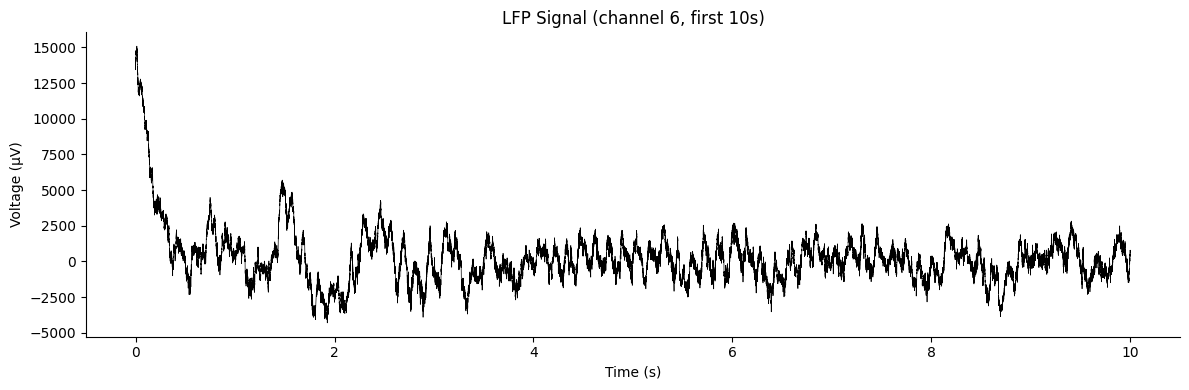

In [14]:
# Plot LFP trace
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(lfp_time, lfp_sample, linewidth=0.5, color="black")

ax.set(
    xlabel="Time (s)",
    ylabel="Voltage (µV)",
    title=f"LFP Signal (channel {theta_ref_channel}, first {SAMPLE_DURATION}s)",
)

ax.spines[["top", "right"]].set_visible(False)
plt.tight_layout()

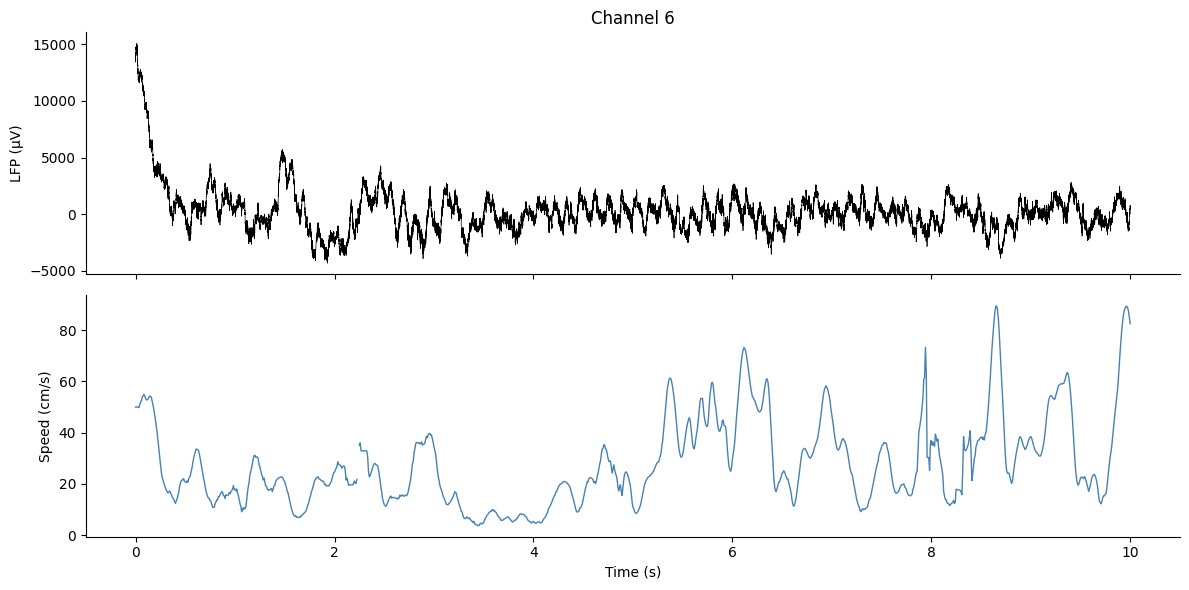

In [15]:
# Plot speed for the same time period (need to align timestamps)
# Speed timestamps are offset from LFP timestamps
speed_offset = speed_timestamps[0]  # Speed starts at this time in the session

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# LFP
ax = axes[0]
ax.plot(lfp_time, lfp_sample, linewidth=0.5, color="black")
ax.set_ylabel("LFP (µV)")
ax.set_title(f"Channel {theta_ref_channel}")
ax.spines[["top", "right"]].set_visible(False)

# Speed (shifted to align with LFP time)
ax = axes[1]
# Find speed samples in the first 10 seconds of the session
speed_mask = (speed_timestamps - speed_offset) < SAMPLE_DURATION
if speed_mask.any():
    ax.plot(
        speed_timestamps[speed_mask] - speed_offset,
        speed_data[speed_mask],
        linewidth=1,
        color="steelblue",
    )
ax.set_xlabel("Time (s)")
ax.set_ylabel(f"Speed ({speed_interface.unit})")
ax.spines[["top", "right"]].set_visible(False)

plt.tight_layout()

## Data Summary

We now have loaded:
- **LFP data**: Raw electrophysiology from the theta reference channel
- **Speed data**: Animal's running speed during the task

The LFP and speed are recorded on different time bases:
- LFP starts at time 0
- Speed/behavior starts at a later time in the session

For analysis, we'll need to align these signals appropriately.

In [16]:
print("Data Summary")
print("=" * 50)
print(f"LFP sampling rate: {lfp_rate} Hz")
print(f"LFP duration: {lfp_duration:.1f} s")
print(f"LFP channels: {lfp_electrical_series.data.shape[1]}")
print(f"Theta reference channel: {theta_ref_channel}")
print()
print(f"Speed samples: {len(speed_data)}")
print(f"Speed time range: {speed_timestamps[0]:.1f} - {speed_timestamps[-1]:.1f} s")
print(f"Behavior epoch offset: {speed_offset:.1f} s from session start")

Data Summary
LFP sampling rate: 20000.0 Hz
LFP duration: 12150.0 s
LFP channels: 128
Theta reference channel: 6

Speed samples: 198664
Speed time range: 6348.1 - 8003.6 s
Behavior epoch offset: 6348.1 s from session start


## Building Intuition with Synthetic Signals

Before analyzing real LFP data, let's build intuition for spectral analysis using
signals where we know the answer. The core idea: any signal can be represented as
a sum of sinusoids at different frequencies. The **power spectrum** tells us which
frequencies are present and how strong they are.

### A Single Sinusoid

The simplest rhythmic signal is a cosine wave. A cosine at frequency $f$ completes
$f$ full cycles per second:

$$V(t) = A \cos(2\pi f t)$$

Let's create a theta-like oscillation at 8 Hz — similar to what we see in the
hippocampus during active navigation.

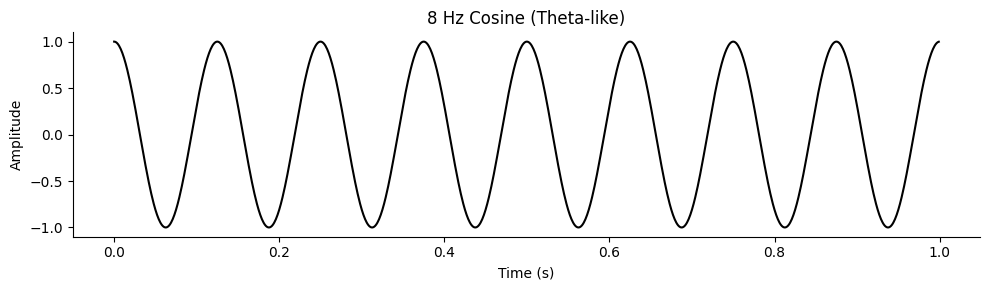

In [17]:
# Create a 1-second signal sampled at 1000 Hz
synth_rate = 1000  # Hz
synth_duration = 1.0  # seconds
t = np.arange(0, synth_duration, 1 / synth_rate)

# Single 8 Hz cosine (theta-like)
signal_8hz = np.cos(2 * np.pi * 8 * t)

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(t, signal_8hz, color="black")
ax.set(xlabel="Time (s)", ylabel="Amplitude", title="8 Hz Cosine (Theta-like)")
ax.spines[["top", "right"]].set_visible(False)
plt.tight_layout()

### Sum of Two Sinusoids

Real brain signals contain multiple rhythms superimposed. Let's create a signal
with two components: a slow, large-amplitude oscillation (5 Hz) and a fast,
small-amplitude oscillation (40 Hz):

$$V(t) = 1.0 \cos(2\pi \cdot 5 \cdot t) + 0.1 \cos(2\pi \cdot 40 \cdot t)$$

**Q:** Can you identify both rhythms by eye?

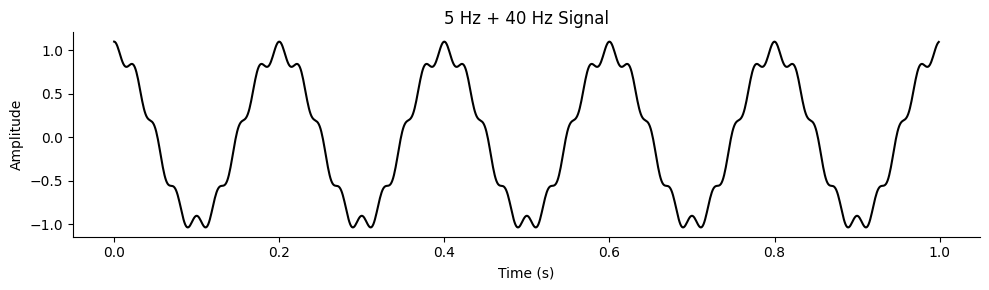

In [18]:
# Sum of a 5 Hz (large amplitude) and 40 Hz (small amplitude) sinusoid
signal_mixed = 1.0 * np.cos(2 * np.pi * 5 * t) + 0.1 * np.cos(2 * np.pi * 40 * t)

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(t, signal_mixed, color="black")
ax.set(xlabel="Time (s)", ylabel="Amplitude", title="5 Hz + 40 Hz Signal")
ax.spines[["top", "right"]].set_visible(False)
plt.tight_layout()

### Computing the Power Spectrum

The **Fourier transform** decomposes a signal into its sinusoidal components.
For discrete data, we use the **Fast Fourier Transform (FFT)** — an efficient
algorithm to compute the discrete Fourier transform.

The **power spectrum** $S_{xx}$ tells us how much power (amplitude squared) is
present at each frequency:

$$S_{xx,j} = \frac{2 \Delta^2}{T} |X_j|^2$$

where $X_j$ is the Fourier transform at frequency $f_j$, $\Delta$ is the sampling
interval, and $T$ is the total duration.

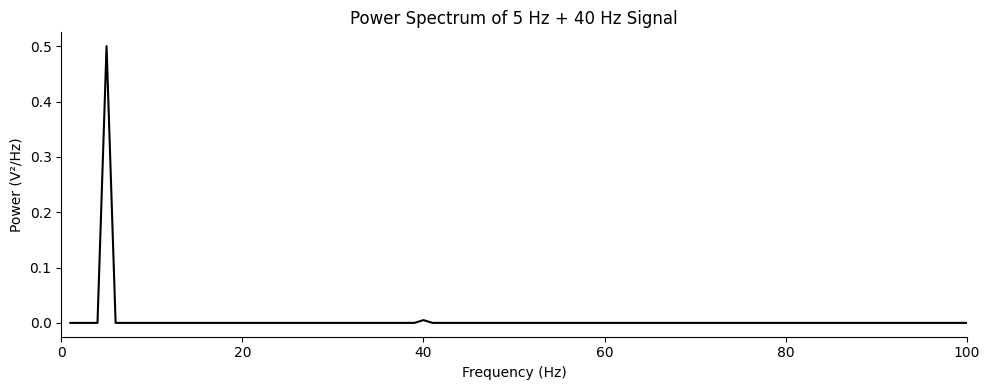

In [19]:
# Compute the FFT of the mixed signal
N = len(signal_mixed)
dt = 1 / synth_rate  # sampling interval (seconds)
T = N * dt  # total duration (seconds)

# np.fft.fft computes the discrete Fourier transform
X = np.fft.fft(signal_mixed)

# np.fft.fftfreq returns the frequencies corresponding to each FFT bin
freqs = np.fft.fftfreq(N, d=dt)

# Compute the power spectrum (one-sided: positive frequencies only)
# Factor of 2 accounts for folding negative frequencies into positive
power = (2 * dt**2 / T) * np.abs(X) ** 2

# Keep only positive frequencies (negative frequencies are redundant for real signals)
pos_mask = freqs > 0
freqs_pos = freqs[pos_mask]
power_pos = power[pos_mask]

# Plot the power spectrum
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(freqs_pos, power_pos, color="black")
ax.set(
    xlabel="Frequency (Hz)",
    ylabel="Power (V²/Hz)",
    title="Power Spectrum of 5 Hz + 40 Hz Signal",
    xlim=(0, 100),
)
ax.spines[["top", "right"]].set_visible(False)
plt.tight_layout()

The spectrum reveals two sharp peaks at exactly **5 Hz** and **40 Hz** — the
frequencies we put in. The 5 Hz peak is much larger because its amplitude (1.0)
is 10× the 40 Hz amplitude (0.1), and power scales as amplitude squared.

This is the central idea of spectral analysis: **decompose a complex signal into
its frequency components and identify the dominant rhythms**.

## Power Spectrum of Real LFP

Now let's apply the same approach to real hippocampal LFP. Before computing the
spectrum, we need to consider two practical issues:

1. **Subtract the mean (detrend)**: The mean voltage is a constant offset (DC
   component at 0 Hz). If left in, it dominates the spectrum and makes real
   rhythms harder to see.

2. **Units**: The power spectrum has units of V²/Hz ("power spectral density").
   We often plot in **decibels** (dB) using $10 \log_{10}(S_{xx})$ to compress
   the dynamic range and reveal lower-amplitude signals.

Two key quantities determine what frequencies we can observe:

- **Nyquist frequency** $f_{NQ} = f_0 / 2$: The highest observable frequency
  (half the sampling rate)
- **Frequency bin spacing** $df = 1/T$: The spacing between frequency bins
  (set by recording duration). Note: this is *not* the same as frequency
  resolution, which depends on the taper/window used (main lobe width).

In [20]:
# Load a longer segment for better frequency resolution
# Align with the behavior epoch so we can overlay speed later
ANALYSIS_DURATION = 60  # seconds
n_analysis = int(ANALYSIS_DURATION * lfp_rate)
behavior_start_sample = int(speed_timestamps[0] * lfp_rate)
lfp_segment = lfp_electrical_series.data[
    behavior_start_sample : behavior_start_sample + n_analysis, theta_ref_channel
]

print(f"Loaded {ANALYSIS_DURATION}s of LFP ({n_analysis} samples)")
print(f"LFP epoch starts at {speed_timestamps[0]:.1f}s (aligned to behavior)")

# Key spectral quantities
nyquist_freq = lfp_rate / 2
freq_bin_spacing = 1 / ANALYSIS_DURATION

print(f"Nyquist frequency: {nyquist_freq:.1f} Hz (highest observable frequency)")
print(f"Frequency bin spacing: {freq_bin_spacing:.4f} Hz (1/T, set by duration)")

Loaded 60s of LFP (1200000 samples)
LFP epoch starts at 6348.1s (aligned to behavior)
Nyquist frequency: 10000.0 Hz (highest observable frequency)
Frequency bin spacing: 0.0167 Hz (1/T, set by duration)


In [21]:
# Subtract the mean to remove the DC component
lfp_detrended = lfp_segment - np.mean(lfp_segment)

# Compute the power spectrum
N_lfp = len(lfp_detrended)
dt_lfp = 1 / lfp_rate
T_lfp = N_lfp * dt_lfp

X_lfp = np.fft.fft(lfp_detrended)
freqs_lfp = np.fft.fftfreq(N_lfp, d=dt_lfp)
power_lfp = (2 * dt_lfp**2 / T_lfp) * np.abs(X_lfp) ** 2

# Keep positive frequencies only
pos_mask_lfp = freqs_lfp > 0
freqs_lfp_pos = freqs_lfp[pos_mask_lfp]
power_lfp_pos = power_lfp[pos_mask_lfp]

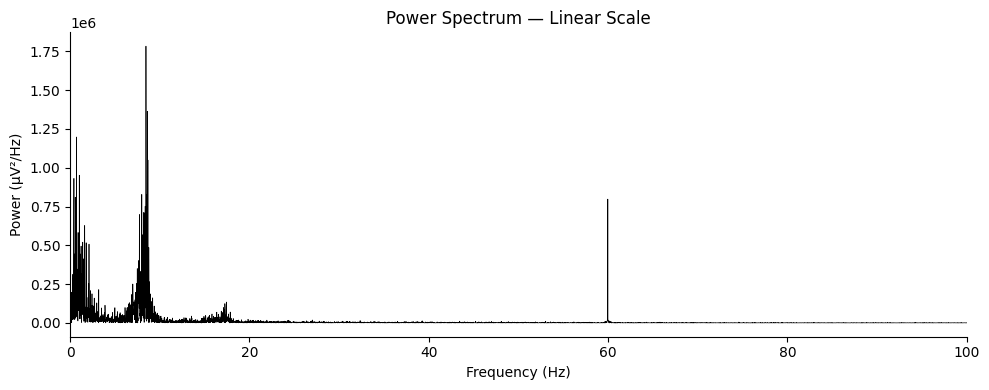

In [22]:
# Plot in linear scale — hard to see structure beyond the dominant peak
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(freqs_lfp_pos, power_lfp_pos, color="black", linewidth=0.5)
ax.set(
    xlabel="Frequency (Hz)",
    ylabel="Power (µV²/Hz)",
    title="Power Spectrum — Linear Scale",
    xlim=(0, 100),
)
ax.spines[["top", "right"]].set_visible(False)
plt.tight_layout()

In linear scale, the low-frequency power dominates and it's hard to see
rhythmic peaks. Let's switch to a **decibel scale** which compresses the
dynamic range.

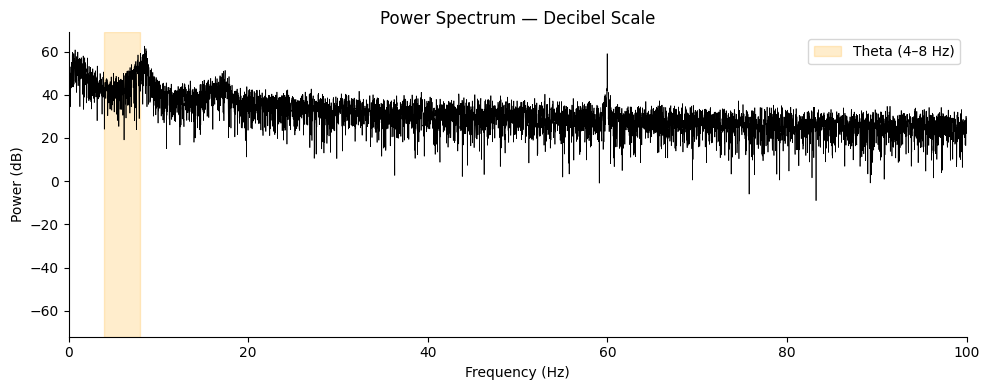

In [23]:
# Plot in decibel scale — reveals structure across frequencies
power_db = 10 * np.log10(power_lfp_pos)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(freqs_lfp_pos, power_db, color="black", linewidth=0.5)

# Annotate the theta band (4-8 Hz)
ax.axvspan(4, 8, alpha=0.2, color="orange", label="Theta (4–8 Hz)")

ax.set(
    xlabel="Frequency (Hz)",
    ylabel="Power (dB)",
    title="Power Spectrum — Decibel Scale",
    xlim=(0, 100),
)
ax.legend()
ax.spines[["top", "right"]].set_visible(False)
plt.tight_layout()

In the dB-scale plot, we can now see:

- A **theta peak** around 6–8 Hz — the dominant hippocampal rhythm during navigation
- A general **1/f trend** — power decreases with frequency, typical of neural signals
- Possible peaks at higher harmonics of theta

However, this "naive" spectrum (using a rectangular window) suffers from
**spectral leakage** — power from strong peaks smears into neighboring frequencies.
We'll address this next.

## Tapering and Spectral Leakage

When we compute the FFT of a finite signal, we implicitly assume the signal
repeats forever. In reality, we observe a finite chunk — as if we multiplied
the infinite signal by a **rectangular window** (1 inside, 0 outside).

This rectangular truncation causes **spectral leakage**: power from a peak
"leaks" into neighboring frequencies as sidelobes. The Fourier transform of a
rectangular window is a sinc function, which has large sidelobes.

> *"More lives have been lost looking at the [rectangular tapered spectrum] than
> by any other action involving time series."* — Tukey, 1980

**Solution**: Multiply the signal by a smooth **taper** (e.g., Hann window) that
tapers to zero at the edges. This reduces sidelobes at the cost of a slightly
wider main lobe.

In [24]:
# Demonstrate spectral leakage with a pure 20 Hz sinusoid
synth_N = 1000
synth_dt = 1 / 1000  # 1 kHz sampling
synth_t = np.arange(synth_N) * synth_dt
synth_T = synth_N * synth_dt

# Pure 20 Hz sinusoid
signal_20hz = np.cos(2 * np.pi * 20 * synth_t)

# Spectrum with rectangular window (no taper)
X_rect = np.fft.fft(signal_20hz)
freqs_synth = np.fft.fftfreq(synth_N, d=synth_dt)
power_rect = (2 * synth_dt**2 / synth_T) * np.abs(X_rect) ** 2

# Spectrum with Hann window
# Correct for the window's noise-equivalent bandwidth (NENBW) so that
# power levels are comparable to the rectangular-window spectrum
hann_window = hann(synth_N)
hann_nenbw = np.mean(hann_window**2)  # ~0.375 for Hann
signal_hann = signal_20hz * hann_window
X_hann = np.fft.fft(signal_hann)
power_hann = (2 * synth_dt**2 / synth_T) * np.abs(X_hann) ** 2 / hann_nenbw

# Keep positive frequencies
synth_pos = freqs_synth > 0
freqs_synth_pos = freqs_synth[synth_pos]
power_rect_pos = power_rect[synth_pos]
power_hann_pos = power_hann[synth_pos]

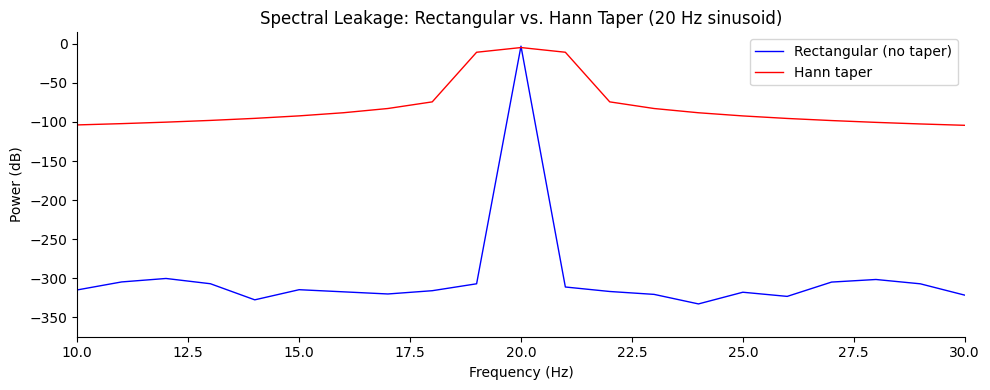

In [25]:
# Compare rectangular vs Hann taper on the 20 Hz sinusoid
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    freqs_synth_pos,
    10 * np.log10(power_rect_pos),
    color="blue",
    linewidth=1,
    label="Rectangular (no taper)",
)
ax.plot(
    freqs_synth_pos,
    10 * np.log10(power_hann_pos),
    color="red",
    linewidth=1,
    label="Hann taper",
)
ax.set(
    xlabel="Frequency (Hz)",
    ylabel="Power (dB)",
    title="Spectral Leakage: Rectangular vs. Hann Taper (20 Hz sinusoid)",
    xlim=(10, 30),
)
ax.legend()
ax.spines[["top", "right"]].set_visible(False)
plt.tight_layout()

Key observations:

- **Rectangular window** (blue): Sharp peak at 20 Hz but large **sidelobes**
  extending far from the peak — this is spectral leakage
- **Hann taper** (red): Sidelobes are greatly reduced (~32 dB down vs ~13 dB),
  but the main lobe is **wider** — reduced frequency resolution

This is the **fundamental tradeoff** in spectral analysis:
narrow main lobe (good resolution) ↔ low sidelobes (less leakage).
Sidelobe bias is generally worse because it can create phantom peaks and
contaminate distant frequency bins.

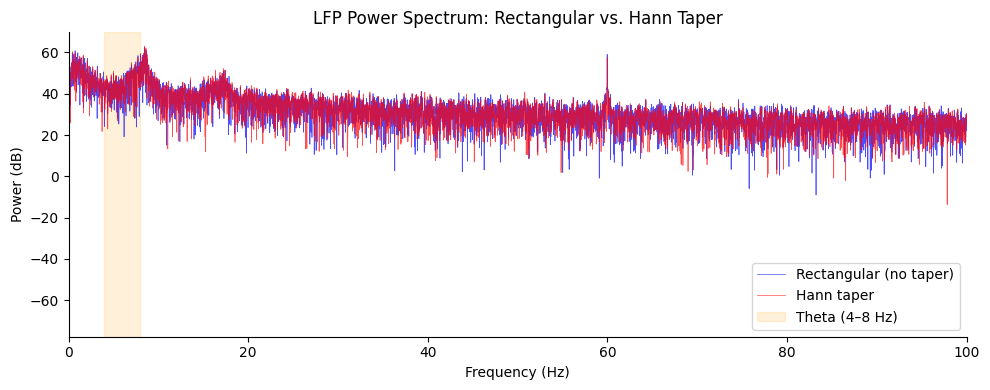

In [26]:
# Apply tapering to real LFP data
hann_lfp = hann(N_lfp)
hann_lfp_nenbw = np.mean(hann_lfp**2)
lfp_hann = lfp_detrended * hann_lfp

X_lfp_hann = np.fft.fft(lfp_hann)
power_lfp_hann = (2 * dt_lfp**2 / T_lfp) * np.abs(X_lfp_hann) ** 2 / hann_lfp_nenbw
power_lfp_hann_pos = power_lfp_hann[pos_mask_lfp]

# Compare untapered vs Hann-tapered LFP spectrum
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    freqs_lfp_pos,
    10 * np.log10(power_lfp_pos),
    color="blue",
    linewidth=0.5,
    alpha=0.7,
    label="Rectangular (no taper)",
)
ax.plot(
    freqs_lfp_pos,
    10 * np.log10(power_lfp_hann_pos),
    color="red",
    linewidth=0.5,
    alpha=0.7,
    label="Hann taper",
)
ax.axvspan(4, 8, alpha=0.15, color="orange", label="Theta (4–8 Hz)")
ax.set(
    xlabel="Frequency (Hz)",
    ylabel="Power (dB)",
    title="LFP Power Spectrum: Rectangular vs. Hann Taper",
    xlim=(0, 100),
)
ax.legend()
ax.spines[["top", "right"]].set_visible(False)
plt.tight_layout()

The Hann-tapered spectrum is slightly smoother with reduced leakage, but both
spectra are still noisy — each frequency bin has high variance. To get a more
stable spectral estimate, we need **multitaper methods**.

## Multitaper Spectral Estimation

A single taper gives one noisy estimate of the spectrum. The **multitaper method**
(Thomson, 1982) uses a family of orthogonal tapers called **discrete prolate
spheroidal sequences (DPSS)** or Slepian tapers to obtain multiple independent
spectral estimates from the same data, then averages them.

Key parameters:

- **Time-bandwidth product** $p = W \cdot T$: Controls the tradeoff between
  frequency resolution (set by the main lobe width $2W$) and number of tapers.
  Larger $p$ = more tapers = lower variance, but coarser frequency resolution.
- **Number of tapers** $k = 2p - 1$: The number of DPSS tapers with good
  spectral concentration.

Advantages of multitaper estimation:

- **Much lower variance** (more stable spectra)
- **Less spectral leakage** (DPSS tapers are optimally concentrated)
- **Principled uncertainty estimates**

We'll use the [`spectral_connectivity`](https://github.com/Eden-Kramer-Lab/spectral_connectivity)
package, which provides a clean interface for multitaper analysis.

### Visualizing DPSS Tapers

The DPSS tapers are orthogonal functions that maximize their energy within a
specified frequency bandwidth $[-W, W]$. Because they are orthogonal, each taper
provides an independent spectral estimate.

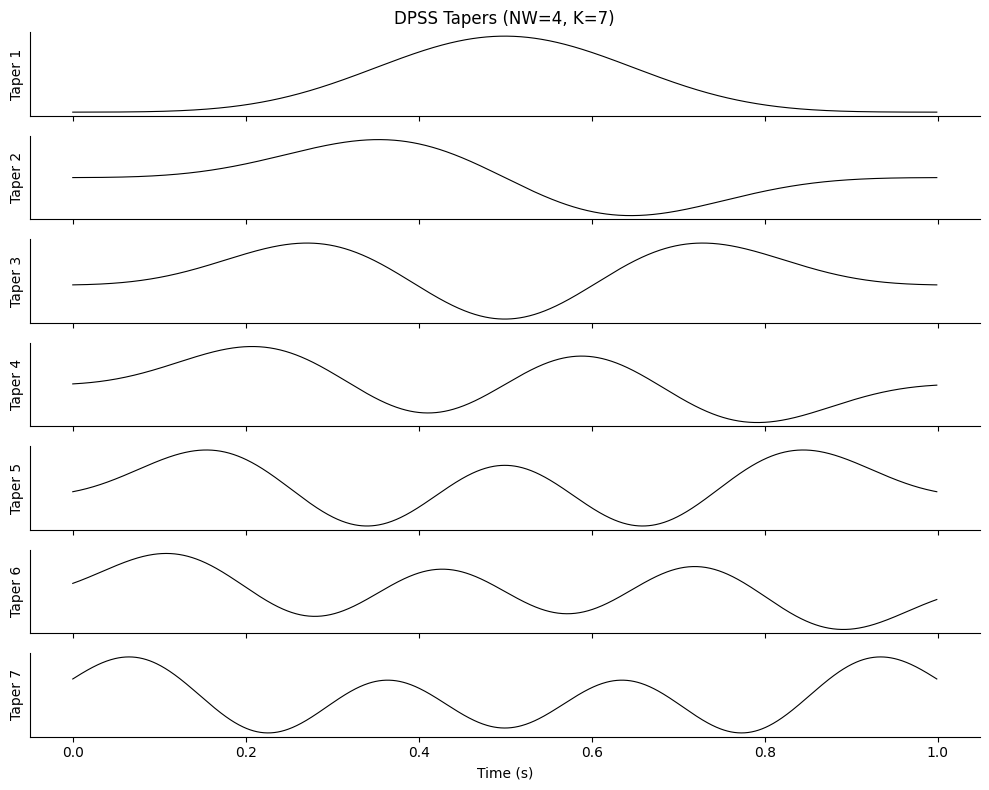

In [27]:
# Compute DPSS tapers for a 1-second window at 1000 Hz
# time_halfbandwidth_product (NW) = 4, giving k = 2*4 - 1 = 7 usable tapers
taper_N = 1000  # samples (1 second at 1 kHz)
NW = 4  # time-halfbandwidth product
K = 2 * NW - 1  # number of good tapers
tapers = dpss(taper_N, NW, Kmax=K)

fig, axes = plt.subplots(K, 1, figsize=(10, 8), sharex=True)
taper_time = np.arange(taper_N) / 1000  # time in seconds

for i, ax in enumerate(axes):
    ax.plot(taper_time, tapers[i], color="black", linewidth=0.8)
    ax.set_ylabel(f"Taper {i + 1}")
    ax.spines[["top", "right"]].set_visible(False)
    ax.set_yticks([])

axes[-1].set_xlabel("Time (s)")
axes[0].set_title(f"DPSS Tapers (NW={NW}, K={K})")
plt.tight_layout()

Each taper has a different shape but all are concentrated in the time window.
In the frequency domain, their energy is concentrated within the bandwidth
$[-W, W]$. By applying each taper to the data and computing the FFT, we get
$k$ independent spectral estimates that we can average for a more stable result.

### Computing the Multitaper Spectrum

The `spectral_connectivity` package handles the multitaper computation:

1. Create a `Multitaper` object with the data and parameters
2. Create a `Connectivity` object from the multitaper
3. Call `.power()` to get the multitaper power spectrum

In [28]:
# Compute multitaper spectrum of the LFP segment
# The data must be 3D: (n_time_samples, n_trials, n_signals)
multitaper = Multitaper(
    lfp_detrended[:, np.newaxis, np.newaxis],
    sampling_frequency=lfp_rate,
    time_halfbandwidth_product=4,
    detrend_type="constant",  # subtract mean (redundant here, but explicit)
)

connectivity = Connectivity.from_multitaper(multitaper)
mt_power = connectivity.power().squeeze()
mt_freqs = connectivity.frequencies

print(f"Frequency resolution (bandwidth 2W): {multitaper.frequency_resolution:.4f} Hz")
print(f"Number of tapers: {multitaper.n_tapers}")
print(f"Nyquist frequency: {multitaper.nyquist_frequency:.1f} Hz")

Frequency resolution (bandwidth 2W): 0.1333 Hz
Number of tapers: 7
Nyquist frequency: 10000.0 Hz


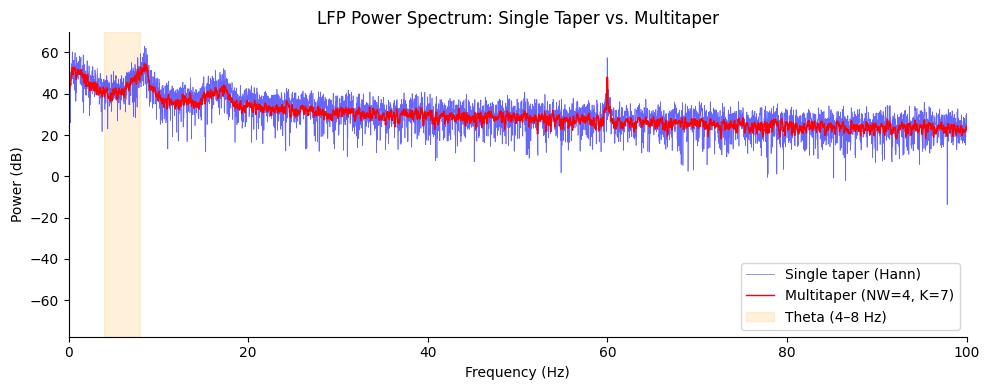

In [29]:
# Compare multitaper vs single-taper (Hann) spectrum
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(
    freqs_lfp_pos,
    10 * np.log10(power_lfp_hann_pos),
    color="blue",
    linewidth=0.5,
    alpha=0.6,
    label="Single taper (Hann)",
)
ax.plot(
    mt_freqs,
    10 * np.log10(mt_power),
    color="red",
    linewidth=1,
    label="Multitaper (NW=4, K=7)",
)

ax.axvspan(4, 8, alpha=0.15, color="orange", label="Theta (4–8 Hz)")
ax.set(
    xlabel="Frequency (Hz)",
    ylabel="Power (dB)",
    title="LFP Power Spectrum: Single Taper vs. Multitaper",
    xlim=(0, 100),
)
ax.legend()
ax.spines[["top", "right"]].set_visible(False)
plt.tight_layout()

The multitaper spectrum (red) is much **smoother** than the single-taper spectrum
(blue) while preserving the same spectral features. The theta peak is clearly
visible without the high-frequency noise that plagues single-taper estimates.

### Effect of Time-Bandwidth Product

The time-bandwidth product controls the bias-variance tradeoff:

- **Small NW** (e.g., 2): Fewer tapers, higher variance, but better frequency
  resolution — can distinguish closely spaced peaks
- **Large NW** (e.g., 4): More tapers, lower variance, but wider bandwidth —
  nearby peaks may merge

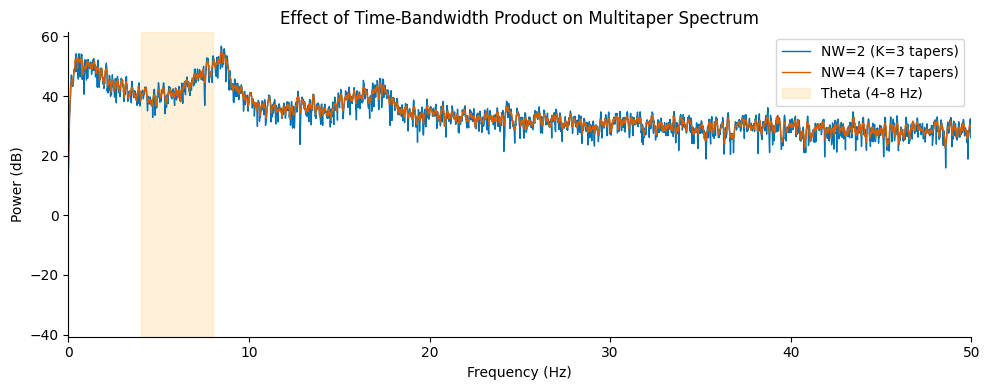

In [30]:
# Compare different time-bandwidth products
fig, ax = plt.subplots(figsize=(10, 4))

for nw, color in [(2, "#0072B2"), (4, "#D55E00")]:
    mt = Multitaper(
        lfp_detrended[:, np.newaxis, np.newaxis],
        sampling_frequency=lfp_rate,
        time_halfbandwidth_product=nw,
        detrend_type="constant",
    )
    conn = Connectivity.from_multitaper(mt)
    power_nw = conn.power().squeeze()
    k = 2 * nw - 1
    ax.plot(
        conn.frequencies,
        10 * np.log10(power_nw),
        linewidth=1,
        color=color,
        label=f"NW={nw} (K={k} tapers)",
    )

ax.axvspan(4, 8, alpha=0.15, color="orange", label="Theta (4–8 Hz)")
ax.set(
    xlabel="Frequency (Hz)",
    ylabel="Power (dB)",
    title="Effect of Time-Bandwidth Product on Multitaper Spectrum",
    xlim=(0, 50),
)
ax.legend()
ax.spines[["top", "right"]].set_visible(False)
plt.tight_layout()

With NW=2, the spectrum has finer frequency resolution but more variability.
With NW=4, the spectrum is smoother but peaks are slightly broader. The choice
depends on whether you need to resolve closely spaced peaks (use lower NW) or
want a stable overall picture (use higher NW).

## Spectrogram: Time-Varying Spectrum

The power spectrum above averages over the entire 60-second segment, but brain
rhythms change over time. **Theta power** is strong when the animal is running
and weak during immobility. **Sharp-wave ripples** appear in brief bursts during
rest.

The **spectrogram** addresses this by dividing the signal into short, overlapping
windows and computing the spectrum in each window. The result is a 2D
representation: **power as a function of both time and frequency**.

There is a fundamental **time-frequency tradeoff**:

- **Short windows** → good time resolution, poor frequency resolution
- **Long windows** → good frequency resolution, poor time resolution

This is because frequency bin spacing scales as $df = 1/T_{window}$: shorter
windows mean coarser frequency bins.

In [31]:
# Compute multitaper spectrogram using spectral_connectivity
# Use 500 ms windows with 100 ms steps
mt_spectrogram = Multitaper(
    lfp_detrended[:, np.newaxis, np.newaxis],
    sampling_frequency=lfp_rate,
    time_halfbandwidth_product=4,
    time_window_duration=0.5,  # 500 ms windows
    time_window_step=0.1,  # 100 ms step (80% overlap)
    detrend_type="constant",
)

conn_spectrogram = Connectivity.from_multitaper(mt_spectrogram)
spec_power = conn_spectrogram.power().squeeze()  # (n_time_windows, n_frequencies)
spec_freqs = conn_spectrogram.frequencies
spec_time = mt_spectrogram.time

print(f"Spectrogram shape: {spec_power.shape}")
print(f"Time windows: {len(spec_time)}")
print(f"Frequency bins: {len(spec_freqs)}")
print(f"Frequency resolution (bandwidth 2W): {mt_spectrogram.frequency_resolution:.1f} Hz")

Spectrogram shape: (596, 5001)
Time windows: 596
Frequency bins: 5001
Frequency resolution (bandwidth 2W): 16.0 Hz


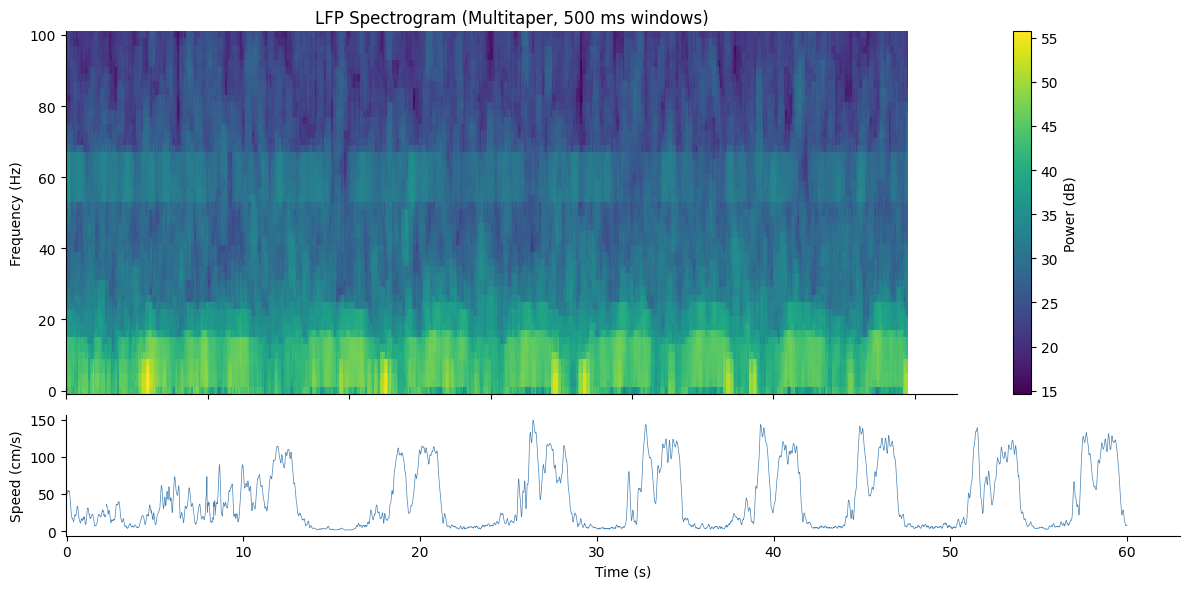

In [32]:
# Plot spectrogram with speed overlay
freq_limit = 100  # Hz
freq_mask = spec_freqs <= freq_limit

fig, axes = plt.subplots(
    2, 1, figsize=(12, 6), sharex=True, gridspec_kw={"height_ratios": [3, 1]}
)

# Spectrogram
ax = axes[0]
mesh = ax.pcolormesh(
    spec_time,
    spec_freqs[freq_mask],
    10 * np.log10(spec_power[:, freq_mask].T),
    shading="auto",
    cmap="viridis",
)
ax.set(ylabel="Frequency (Hz)", title="LFP Spectrogram (Multitaper, 500 ms windows)")
ax.spines[["top", "right"]].set_visible(False)
plt.colorbar(mesh, ax=ax, label="Power (dB)")

# Speed overlay (aligned to the same epoch as LFP)
ax = axes[1]
speed_relative = speed_timestamps - speed_timestamps[0]
speed_mask_full = speed_relative < ANALYSIS_DURATION
if speed_mask_full.any():
    ax.plot(
        speed_relative[speed_mask_full],
        speed_data[speed_mask_full],
        linewidth=0.5,
        color="steelblue",
    )
ax.set(xlabel="Time (s)", ylabel=f"Speed ({speed_interface.unit})")
ax.spines[["top", "right"]].set_visible(False)

plt.tight_layout()

The spectrogram reveals how spectral content changes over time. Compare the
spectrogram with the speed trace below it:

- **During running** (high speed): Theta power (~6–8 Hz) should be prominent
- **During immobility** (low speed): Theta power decreases; brief high-frequency
  events (sharp-wave ripples) may appear

### Time-Frequency Tradeoff

Let's demonstrate the tradeoff by comparing spectrograms with different window
lengths. Shorter windows give better time precision but coarser frequency bins.

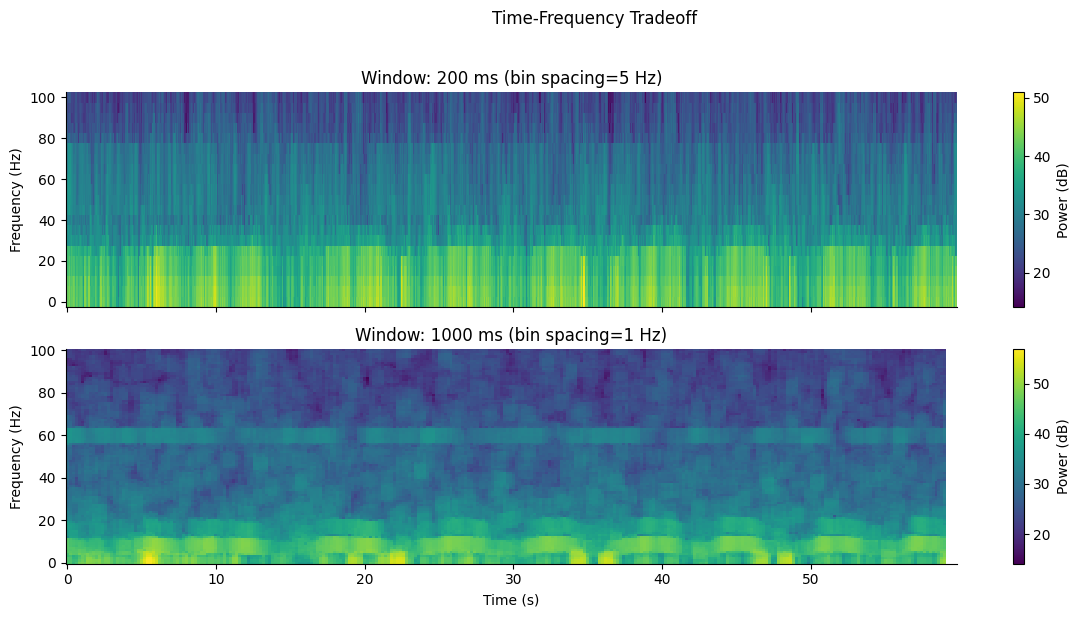

In [33]:
# Compare short vs long windows
window_durations = [0.2, 1.0]  # seconds
window_labels = ["200 ms (bin spacing=5 Hz)", "1000 ms (bin spacing=1 Hz)"]

fig, axes = plt.subplots(len(window_durations), 1, figsize=(12, 6), sharex=True)

for ax, win_dur, label in zip(axes, window_durations, window_labels):
    mt_win = Multitaper(
        lfp_detrended[:, np.newaxis, np.newaxis],
        sampling_frequency=lfp_rate,
        time_halfbandwidth_product=4,
        time_window_duration=win_dur,
        time_window_step=win_dur / 5,  # 80% overlap
        detrend_type="constant",
    )
    conn_win = Connectivity.from_multitaper(mt_win)
    pwr = conn_win.power().squeeze()
    f = conn_win.frequencies
    t_win = mt_win.time

    f_mask = f <= freq_limit
    mesh = ax.pcolormesh(
        t_win,
        f[f_mask],
        10 * np.log10(pwr[:, f_mask].T),
        shading="auto",
        cmap="viridis",
    )
    ax.set(ylabel="Frequency (Hz)", title=f"Window: {label}")
    ax.spines[["top", "right"]].set_visible(False)
    plt.colorbar(mesh, ax=ax, label="Power (dB)")

axes[-1].set_xlabel("Time (s)")
fig.suptitle("Time-Frequency Tradeoff", y=1.02)
plt.tight_layout()

- **Short windows** (200 ms, top): Good temporal resolution — you can see when
  events start and stop. But frequency bin spacing is coarse (5 Hz), so the
  theta peak is broad and hard to pinpoint.
- **Long windows** (1000 ms, bottom): Frequency bin spacing is fine (1 Hz) —
  theta peak is sharp. But temporal resolution is coarse, smoothing over rapid
  changes.

There is no "right" window length — it depends on what you want to see. For
studying theta dynamics, windows of 0.5–1.0 s are common. For detecting brief
sharp-wave ripples, shorter windows are needed.

## Exercises

Try these on your own to deepen your understanding of LFP spectral analysis:

1. **Different channels**: Load LFP from a different electrode channel and compare
   its power spectrum to the theta reference channel. Do all channels show the
   same theta peak?

2. **Frequency bin spacing**: Re-run the power spectrum analysis with 10 s vs 120 s
   of data. How does the frequency bin spacing change? Can you better resolve the
   theta peak with more data?

3. **Time-bandwidth product**: Try multitaper spectra with `time_halfbandwidth_product`
   values of 1.5, 3, and 6. How does this affect the smoothness vs. resolution
   of the spectrum?

4. **Running vs. immobility**: Use the speed data to separate LFP into epochs when
   the animal is running (speed > 4 cm/s) vs. immobile (speed < 1 cm/s). Compare
   their power spectra. Where do you see theta? Where do you see ripples?

5. **Theta power over time**: From the spectrogram, extract the average power in
   the theta band (4–8 Hz) at each time point. Plot this alongside speed. Is
   theta power correlated with running speed?
   (Hint: use `spec_power[:, (spec_freqs >= 4) & (spec_freqs <= 8)].mean(axis=1)`)

6. **Ripple detection**: Look at the spectrogram during periods of immobility.
   Can you identify transient high-frequency events (100–250 Hz) that might
   correspond to sharp-wave ripples? You may need to adjust the frequency range
   and use shorter time windows.

## Summary

In this notebook, we learned how to:

1. **Load LFP and behavioral data** from NWB files streamed from DANDI
2. **Compute power spectra** using the FFT (detrend, transform, compute power)
3. **Identify key spectral quantities**: Nyquist frequency and frequency bin spacing
4. **Understand spectral leakage** and how tapering (Hann window) reduces sidelobes
5. **Apply multitaper estimation** using DPSS tapers via `spectral_connectivity`
6. **Generate spectrograms** to visualize time-varying spectral content
7. **Appreciate the time-frequency tradeoff** in spectrogram analysis

### Key Concepts

| Concept | Description |
|---------|-------------|
| Power spectrum | Decomposition of signal power by frequency |
| Nyquist frequency | Highest observable frequency = sampling rate / 2 |
| Frequency bin spacing | Spacing between frequency bins = 1 / duration |
| Frequency resolution | Ability to distinguish nearby peaks; depends on taper (main lobe width) |
| Spectral leakage | Power smearing from finite observation window |
| Taper / window | Function applied to data to reduce leakage (e.g., Hann) |
| Multitaper (DPSS) | Multiple orthogonal tapers averaged for lower variance |
| Spectrogram | Time-varying power spectrum (power vs. time and frequency) |
| Time-frequency tradeoff | Short windows = good time resolution, coarse frequency bins |

### Python Techniques Used

- **`np.fft.fft`** and **`np.fft.fftfreq`** for computing the discrete Fourier transform
- **`scipy.signal.windows.hann`** and **`scipy.signal.windows.dpss`** for window functions
- **`spectral_connectivity.Multitaper`** for multitaper spectral estimation
- **`spectral_connectivity.Connectivity`** for computing power and spectrograms
- **`ax.pcolormesh`** for plotting 2D spectrograms
- **Decibel scale** (`10 * np.log10(power)`) for visualizing spectral data

### Next Steps

In notebook 04, we'll move from analyzing LFP to **decoding** — using neural
activity (both spikes and LFP) to reconstruct the animal's position. This
connects the neural representations we've characterized to computational models
of spatial coding.

## Cleanup

In [34]:
# Close both file handles
behavior_io.close()
lfp_io.close()